# Official source code of Finestyler

[![GitHub Repo Stars](https://img.shields.io/github/stars/yisuanwang/Finestyler?label=stars&logo=github&color=brightgreen)](https://github.com/yisuanwang/Finestyler)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cn4W7IlooDk5X9JXBvsENRtExKJShb98)

---




In [1]:
#@title Download Packages
import os
import sys
import matplotlib.pyplot as plt


!pip install loguru
!pip install lmdb
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

# test_demo需要替换成yisuanwang的 Finestyler
finestyler_dir = os.path.join("/content", "Finestyler")

!git clone https://github.com/yisuanwang/Finestyler.git $finestyler_dir



!gdown --id 1bwgDvd7IwKGC9c9RCCB6_JEmrEng4wR5 --output $finestyler_dir/best_model.pth

sys.path.append(finestyler_dir)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 2.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-y8wmsito
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-y8wmsito
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=7d38233c746a00ba001ff802208c7cfe8333bfac6efb95d4ed67cb998412fad5
  Stored in directory: /tmp/pip-ephem-wheel-cache-689x1vpq/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Cloning into '/content/Finestyler'...
remote: Enumerating objects: 195, done.
remote: Counting objects: 100% (59/59), done.
remote: Com

In [2]:
#@title Import Packages
from tools.predict import getMask
import cv2
import numpy as np
from matplotlib import pyplot as plt
import style.utils as utils
import clip
from PIL import Image
import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models
import style.StyleNet as StyleNet
import style.utils as utils
import torch.nn.functional as F
from style.template import imagenet_templates
import PIL
from torchvision import utils as vutils
from torchvision.transforms.functional import adjust_contrast
import utils.config as config
import random
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

config_path = "./config/refcoco+/test.yaml"
config_path = os.path.join(finestyler_dir, config_path)

model_pth = "./best_model.pth"
model_pth = os.path.join(finestyler_dir, model_pth)

cuda


In [3]:
#@title Functions
def getMaskImg(img,config_path,model_pth,sent=None,isMask=False,):
    if not isMask:
        img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_style2 = img_style1/255.0
        img_style3 = np.transpose(img_style2, (2,0,1))
        img_style4 = torch.Tensor(img_style3)
        img_style = torch.unsqueeze(img_style4, 0)

        mask0 = getMask(img,sent,config_path,model_pth)
        print("*"*50)
        print(mask0)
        print(config_path)
        print(model_pth)
        mask1 = np.stack((mask0, mask0,mask0), axis=2)
        mask_img = np.array(mask1*255, dtype=np.uint8)
        return mask_img
    else:
        return img

def getCVImg2Torch(img):
    img_style1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_style2 = img_style1/255.0
    img_style3 = np.transpose(img_style2, (2,0,1))
    img_style4 = torch.Tensor(img_style3)
    img_style = torch.unsqueeze(img_style4, 0)
    return img_style

def load_image(img,mode="PLT"):
    if mode == "CV":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        ])
    image = transform(img)[:3, :, :].unsqueeze(0)
    return image.to(device)

def squeeze_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze(0)
    image = torch.Tensor(image)
    return image

def img_normalize(image,device):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize2(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    return image

def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

    return loss_var_l2

def getClipFeature(image,clip_model):
    image = F.interpolate(image,size=224,mode='bicubic')
    image = clip_model.encode_image(image.to(device))
    image = image.mean(axis=0, keepdim=True)
    image /= image.norm(dim=-1, keepdim=True)
    return image

def getVggFeature(image,device,VGG):
    return utils.get_features(img_normalize(image,device), VGG)

def getLoss(text_feature,img_feature):
    return 1-torch.cosine_similarity(text_feature, img_feature)

def getCropImgAndFeature(img,mask,target,clip_model,size=128,batch=64,pot_part=0.9,sizePose=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img, mask, target = img.to(device), mask.to(device), target.to(device)

    back_crop, pot_crop ,pot_aug,extra_pot = [], [],[],[]
    cropper = transforms.RandomCrop(size)
    augment = transforms.Compose([
        transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
        transforms.Resize(400)
    ])

    max_iterations = 20000
    iteration = 0

    while len(pot_crop)<batch and iteration < max_iterations :
        iteration += 1
        if sizePose:
            (i, j, h, w) = sizePose
        else:
            (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)

        if int(mask_crop[0].sum())/(3*size*size) >= 0.8:
            if len(pot_crop)<batch :
                pot_crop.append(img_crop)
                pot_aug.append(augment(target_crop))

    pot_allCrop = torch.cat(pot_crop,dim=0).to(device)
    pot_all_crop = pot_allCrop
    pot_crop_feature = clip_model.encode_image(clip_normalize2(pot_all_crop, device))

    while len(back_crop) < batch and iteration < max_iterations:
        iteration += 1
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) < 0.1:
            img_crop_feature = clip_model.encode_image(clip_normalize2(img_crop,device))
            cos = (1- torch.cosine_similarity(img_crop_feature, pot_crop_feature))
            if torch.numel(cos[cos>0.12]) > 0.8*batch:
                back_crop.append([target_crop,img_crop])

    while len(extra_pot) < 0.1*batch and iteration < max_iterations:
        iteration += 1
        (i, j, h, w) = cropper.get_params(squeeze_convert(mask), (size, size))
        mask_crop = transforms.functional.crop(mask, i, j, h, w)
        img_crop = transforms.functional.crop(img, i, j, h, w)
        target_crop = transforms.functional.crop(target, i, j, h, w)
        if int(mask_crop[0].sum())/(3*size*size) < 0.1:
            img_crop_feature = clip_model.encode_image(clip_normalize2(img_crop,device))
            cos = (1- torch.cosine_similarity(img_crop_feature, pot_crop_feature))
            if torch.numel(cos[cos<0.06]) > 0.2*batch:
                extra_pot.append(augment(target_crop))
                pot_aug.append(augment(target_crop))

    return pot_aug, back_crop


import time

def getTotalLoss(args, content_features, text_features, source_features, text_source, target, device, VGG, clip_model, img, mask):
    target_features = utils.get_features(img_normalize(target,device), VGG)
    content_loss = 0
    content_loss += torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    content_loss += torch.mean((target_features['conv5_2'] - content_features['conv5_2']) ** 2)

    cropper = transforms.Compose([
        transforms.RandomCrop(args.crop_size)
    ])
    augment = transforms.Compose([
        transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
        transforms.Resize(224)
    ])

    loss_patch=0
    img_crop, back_crop = getCropImgAndFeature(img, mask, target, clip_model, size=64, batch=64, pot_part=args.pot_part, sizePose=None)
    img_crop = torch.cat(img_crop,dim=0)
    img_aug = img_crop

    image_features = clip_model.encode_image(clip_normalize(img_aug,device))
    image_features /= (image_features.clone().norm(dim=-1, keepdim=True))
    img_direction = (image_features-source_features)
    img_direction /= img_direction.clone().norm(dim=-1, keepdim=True)

    text_direction = (text_features-text_source).repeat(image_features.size(0),1)
    text_direction /= text_direction.norm(dim=-1, keepdim=True)
    loss_temp = (1- torch.cosine_similarity(img_direction, text_direction, dim=1))
    loss_temp[loss_temp<args.thresh] =0
    loss_patch+=loss_temp.mean()

    loss_back = 0
    lossToBack = torch.nn.MSELoss()
    for i in back_crop:
        a = i[0]
        b = i[1]
        loss_back += lossToBack(a, b)

    loss_glob=0

    reg_tv = args.lambda_tv*get_image_prior_losses(target)
    total_loss = args.lambda_patch*loss_patch + args.lambda_c * content_loss+ reg_tv+ args.lambda_dir*loss_glob + args.lambda_c * loss_back

    detail_loss = {
        "loss_patch":loss_patch,
        "content_loss":content_loss,
        "reg_tv":reg_tv,
        "loss_glob":loss_glob,
        "loss_back":loss_back,
    }

    return total_loss,detail_loss

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

def img_denormalize(image,device):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = image*std +mean
    return image

def img_normalize(image,device):
    mean=torch.tensor([0.485, 0.456, 0.406]).to(device)
    std=torch.tensor([0.229, 0.224, 0.225]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image

def clip_normalize(image,device):
    image = F.interpolate(image,size=224,mode='bicubic')
    mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device)
    std=torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device)
    mean = mean.view(1,-1,1,1)
    std = std.view(1,-1,1,1)

    image = (image-mean)/std
    return image


def get_image_prior_losses(inputs_jit):
    diff1 = inputs_jit[:, :, :, :-1] - inputs_jit[:, :, :, 1:]
    diff2 = inputs_jit[:, :, :-1, :] - inputs_jit[:, :, 1:, :]
    diff3 = inputs_jit[:, :, 1:, :-1] - inputs_jit[:, :, :-1, 1:]
    diff4 = inputs_jit[:, :, :-1, :-1] - inputs_jit[:, :, 1:, 1:]

    loss_var_l2 = torch.norm(diff1) + torch.norm(diff2) + torch.norm(diff3) + torch.norm(diff4)

    return loss_var_l2

def compose_text_with_templates(text: str, templates=imagenet_templates) -> list:
    return [template.format(text) for template in templates]


def getStyleImg(config_path,content_image,source="a Photo",prompt="a Photo",seed=42,get_total_loss=getTotalLoss ,mask=None,save_epoch=False,path=''):
    setup_seed(seed)
    args = config.load_cfg_from_cfg_file(config_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    content_image = content_image.to(device)
    VGG = models.vgg19(pretrained=True).features
    VGG.to(device)
    for parameter in VGG.parameters():
        parameter.requires_grad_(False)

    content_features = utils.get_features(img_normalize(content_image,device), VGG)
    target = content_image.clone().requires_grad_(True).to(device)

    style_net = StyleNet.UNet()
    style_net.to(device)

    optimizer = optim.Adam(style_net.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    steps = args.max_step

    output_image = content_image
    m_cont = torch.mean(content_image,dim=(2,3),keepdim=False).squeeze(0)
    m_cont = [m_cont[0].item(),m_cont[1].item(),m_cont[2].item()]

    cropper = transforms.Compose([
        transforms.RandomCrop(args.crop_size)
    ])
    augment = transforms.Compose([
        transforms.RandomPerspective(fill=0, p=1,distortion_scale=0.5),
        transforms.Resize(224)
    ])

    clip_model, preprocess = clip.load('ViT-B/32', device, jit=False)

    with torch.no_grad():
        template_text = compose_text_with_templates(prompt, imagenet_templates)
        tokens = clip.tokenize(template_text).to(device)
        text_features = clip_model.encode_text(tokens).detach()
        text_features = text_features.mean(axis=0, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        template_source = compose_text_with_templates(source, imagenet_templates)
        tokens_source = clip.tokenize(template_source).to(device)
        text_source = clip_model.encode_text(tokens_source).detach()
        text_source = text_source.mean(axis=0, keepdim=True)
        text_source /= text_source.norm(dim=-1, keepdim=True)
        source_features = clip_model.encode_image(clip_normalize(content_image,device))
        source_features /= (source_features.clone().norm(dim=-1, keepdim=True))

    for epoch in range(0, steps+1):
        scheduler.step()
        target = style_net(content_image,use_sigmoid=True).to(device)
        target.requires_grad_(True)
        ###############
        total_loss, detail_loss = get_total_loss(args,content_features,text_features,source_features,text_source,target,device,VGG,clip_model,content_image,mask)
        ###############
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        if epoch % 20 ==0:
            print('======={}/{}========'.format(epoch, steps+1))
            print('Total loss: ', total_loss.item())
            for k,v in detail_loss.items():
                print(f"{k}:{v}")
            if save_epoch :
                output_image = target.clone()
                output_image = torch.clamp(output_image,0,1)
                output_image = adjust_contrast(output_image,1.5)
                plt.imshow(utils.im_convert2(output_image))
                plt.show()

    output_image = target.clone()
    output_image = torch.clamp(output_image,0,1)
    output_image = adjust_contrast(output_image,1.5)
    # output_image = utils.im_convert2(output_image)
    return output_image



In [4]:
#@title Soulstyler Function
def StyleProcess(img_path, cris_prompt, style_prompt, seed, save_epoch=False, size=128, pot_part=0.8):
    tmp_cris = cris_prompt.replace('.','').replace(' ','_')
    tmp_style = style_prompt.replace('.','').replace(' ','_')

    base_path = f'./outputs/size={size}/pot_part={pot_part}/{tmp_cris}/seed={seed}_{tmp_style}'
    img_output_image_path = os.path.join(base_path, 'ori_img.png')
    mask_output_image_path = os.path.join(base_path, 'mask_img.png')
    result_output_image_path = os.path.join(base_path, 'result_img.png')
    result_epoch_output_image_path = os.path.join(base_path, 'epoch/')

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if save_epoch and not os.path.exists(result_epoch_output_image_path):
        os.makedirs(result_epoch_output_image_path)

    if os.path.exists(result_output_image_path):
        print(f"File '{result_output_image_path}' already exists. Exiting function.")
        return

    img = cv2.imread(img_path)
    mask = getMaskImg(img,config_path,model_pth,cris_prompt,isMask=False)

    img = load_image(img,mode="CV")
    mask = load_image(mask)

    img = img.to(device)
    mask = mask.to(device)

    # show ori image
    plt.imshow(utils.im_convert2(img))
    plt.show()
    # show mask image
    plt.imshow(utils.im_convert2(mask))
    plt.show()

    # save_image(img, img_output_image_path)
    # save_image(mask, mask_output_image_path)

    output_image = getStyleImg(
        config_path, img, source="a Photo",
        prompt=style_prompt,
        seed=seed,
        get_total_loss=getTotalLoss,
        mask=mask,
        save_epoch=save_epoch,
        path = result_epoch_output_image_path
    )

    # result
    plt.figure(figsize=(20, 20))
    plt.imshow(utils.im_convert2(output_image))
    plt.show()

⚠Receiving colab's restricted GPU and LLaMA-2 licensing policy, we only provide Splitting Stylized Instruction, i.e. Stylized Content and Stylized Objects, after LLM segmentation in this colab. The full code containing the LLM split prompt will be described in github.

In [5]:
#@title  Stylized Content and Stylized Objects
style_prompt_list = [
    {'style':"white wool", 'seed':2},
    {'style':"a sketch with crayon", 'seed':3},
    {'style':"oil painting of flowers", 'seed':7},
    {'style':'pop art of night city', 'seed':6},
    {'style':"Starry Night by Vincent van gogh", 'seed':0},
    {'style':"neon light", 'seed':5},
    {'style':"mosaic", 'seed':4},
    {'style':"green crystal", 'seed':1},
    {'style':"Underwater", 'seed':0},
    {'style':"fire", 'seed':0},
    {'style':'a graffiti style painting', 'seed':2},
    {'style':'The great wave off kanagawa by Hokusai', 'seed':0},
    {'style':'Wheatfield by Vincent van gogh', 'seed':2},
    {'style':'a Photo of white cloud', 'seed':3},
    {'style':'a monet style underwater', 'seed':3},
    {'style':'A fauvism style painting', 'seed':2}
]

input_data  = [
    {
        'img_path' : f"{finestyler_dir}/testimg/ship.jpg",
        'cris_prompt' : "A white sailboat with three blue sails floating on the sea"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/911.jpg",
        'cris_prompt' : "a plane"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/1.jpg",
        'cris_prompt' : "a flower"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/house.jpg",
        'cris_prompt' : "a house"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/people.jpg",
        'cris_prompt' : "the face"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/Napoleon.jpg",
        'cris_prompt' : "a White War Horse"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/apple.png",
        'cris_prompt' : "a red apple"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/bigship.png",
        'cris_prompt' : "White Large Luxury Cruise Ship"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/car.png",
        'cris_prompt' : "White sports car."
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/lena.png",
        'cris_prompt' : "A woman's face."
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/mountain.png",
        'cris_prompt' : "mountain peak"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/tjl.jpeg",
        'cris_prompt' : "The White House at the Taj Mahal"
    },
    {
        'img_path' : f"{finestyler_dir}/testimg/man.jpg",
        'cris_prompt' : "The Men's face"
    },
]

In [6]:
print(input_data[0]['img_path'])
print(input_data[0]['cris_prompt'])
print(style_prompt_list[2]['style'])
print(style_prompt_list[2]['seed'])

/content/Finestyler/testimg/ship.jpg
A white sailboat with three blue sails floating on the sea
oil painting of flowers
7


⚠: demo in colab needs to download the model from the internet and may run slowly due to GPU limitations (30s-60s an iter, usually need to train about 200 iters to get better results)

A good result will be presented at about 50 iters, which will take about 20 minutes.

**Running takes a long wait, slide the cell below to see the results already running 😊.**

100%|███████████████████████████████████████| 244M/244M [00:03<00:00, 74.2MiB/s]
2024-09-06 04:38:23.630 | INFO     | model:build_segmenter:46 - Backbone with decay=325, Head=124


vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis.shape=torch.Size([676, 1, 512])
txt.shape=torch.Size([17, 1, 512])
vis_pos.shape=torch.Size([676, 1, 512])
txt_pos.shape=torch.Size([17, 1, 512])
pad_mask.shape=torch.Size([1, 17])
vis2.shape=torch.Size([676, 1, 512])
vis_pos.shape=torch.Size([676, 1, 51

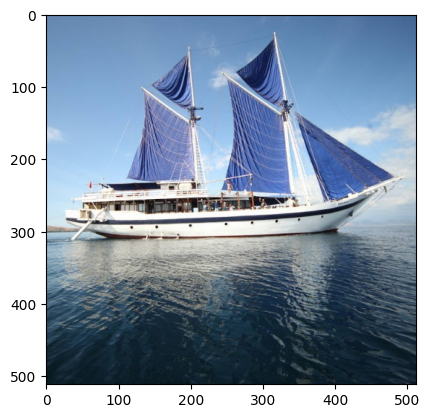

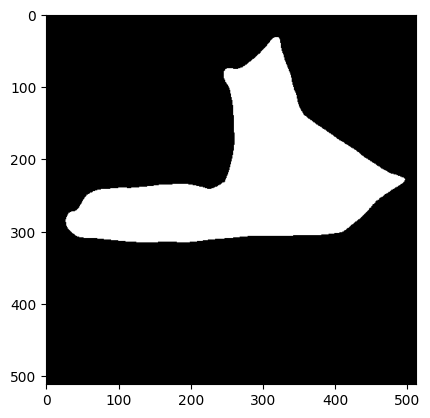

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 156MB/s]
100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 57.0MiB/s]


=======0/201========
Total loss:  9884.400390625
loss_patch:0.90966796875
content_loss:8.599475860595703
reg_tv:0.46674028038978577
loss_glob:0
loss_back:2.70674729347229


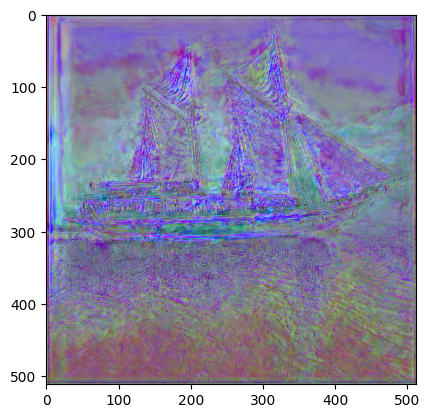

=======20/201========
Total loss:  8238.681640625
loss_patch:0.830078125
content_loss:4.899863243103027
reg_tv:0.2738623321056366
loss_glob:0
loss_back:0.20952610671520233


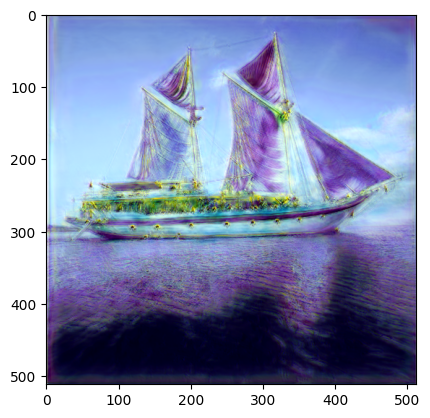

=======40/201========
Total loss:  7741.0205078125
loss_patch:0.7919921875
content_loss:3.924830913543701
reg_tv:0.3106081187725067
loss_glob:0
loss_back:0.15990394353866577


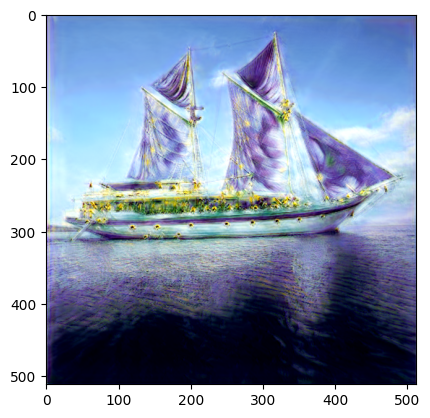

=======60/201========
Total loss:  7524.25732421875
loss_patch:0.78369140625
content_loss:3.0854642391204834
reg_tv:0.34730255603790283
loss_glob:0
loss_back:0.0606011264026165


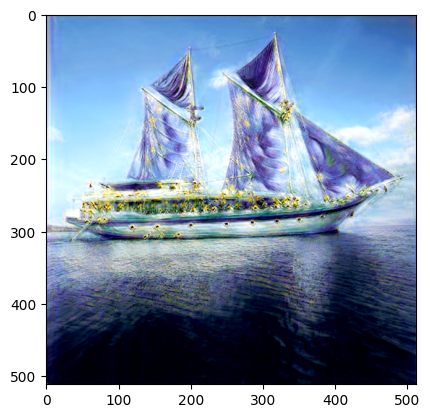

=======80/201========
Total loss:  7294.95947265625
loss_patch:0.76513671875
content_loss:2.6447041034698486
reg_tv:0.3681861162185669
loss_glob:0
loss_back:0.06590580940246582


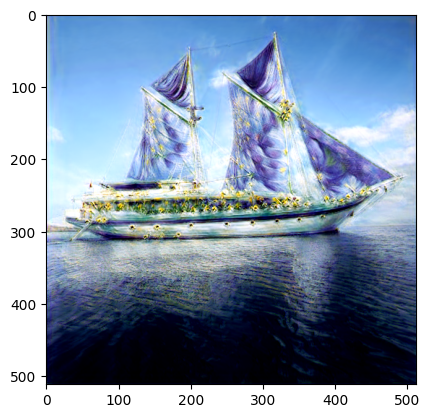

=======100/201========
Total loss:  7240.505859375
loss_patch:0.765625
content_loss:2.261296272277832
reg_tv:0.38682571053504944
loss_glob:0
loss_back:0.05949840322136879


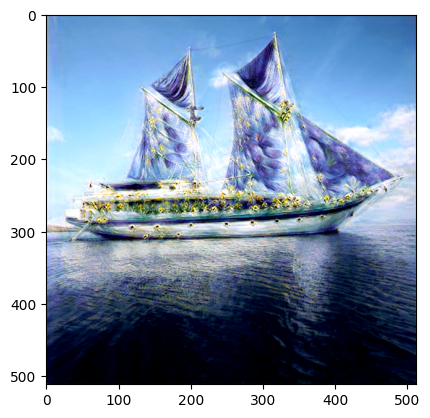

=======120/201========
Total loss:  7074.9169921875
loss_patch:0.751953125
content_loss:1.9583649635314941
reg_tv:0.3977770507335663
loss_glob:0
loss_back:0.08509287238121033


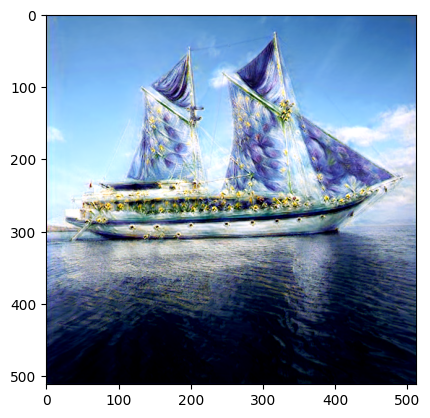

=======140/201========
Total loss:  7050.6494140625
loss_patch:0.75341796875
content_loss:1.7691359519958496
reg_tv:0.41079530119895935
loss_glob:0
loss_back:0.03245498612523079


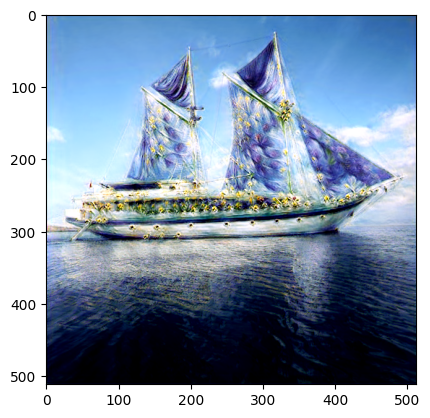

=======160/201========
Total loss:  7016.521484375
loss_patch:0.7509765625
content_loss:1.6752469539642334
reg_tv:0.4226682782173157
loss_glob:0
loss_back:0.032076701521873474


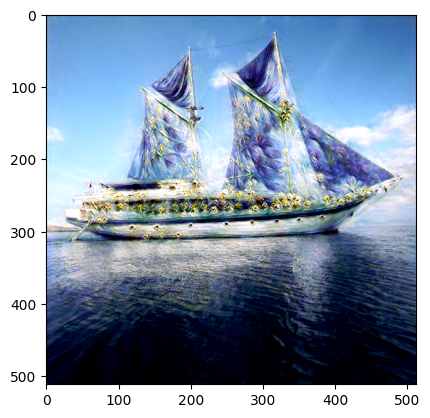

=======180/201========
Total loss:  6941.83984375
loss_patch:0.74365234375
content_loss:1.5743228197097778
reg_tv:0.4325237572193146
loss_glob:0
loss_back:0.08839264512062073


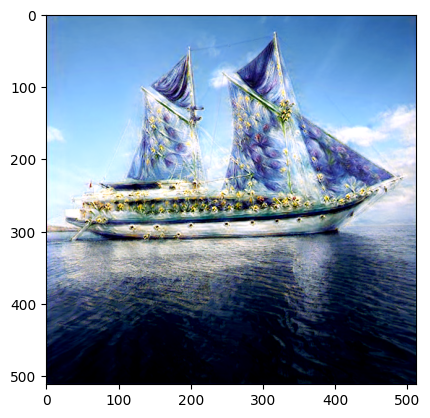

=======200/201========
Total loss:  6886.35107421875
loss_patch:0.73876953125
content_loss:1.544865369796753
reg_tv:0.4457559585571289
loss_glob:0
loss_back:0.0411696657538414


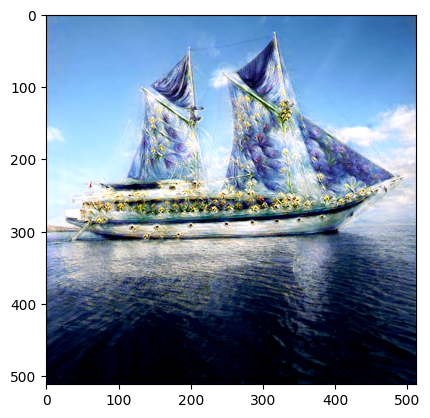

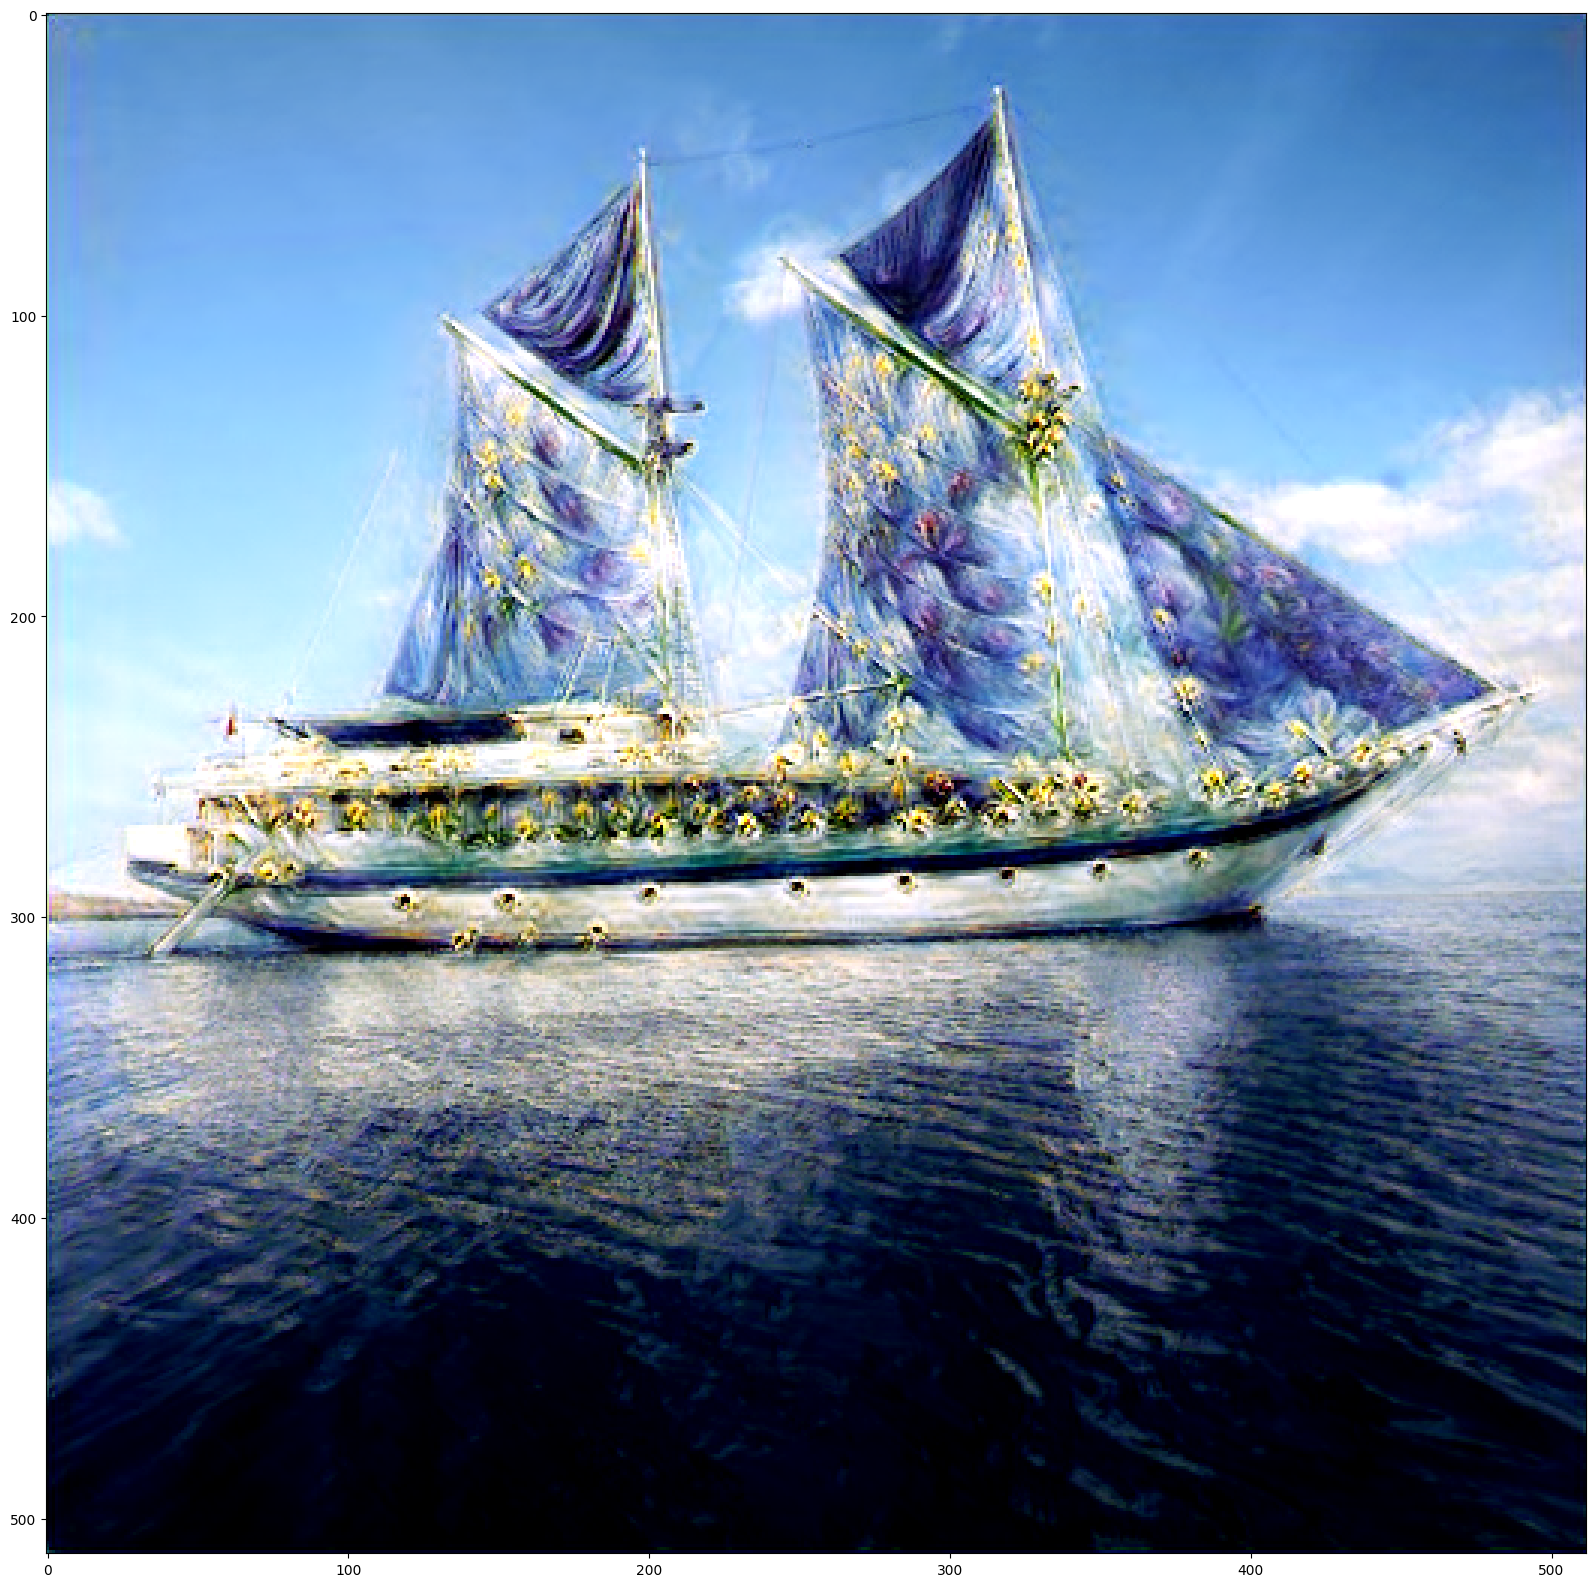

In [7]:
#@title  Have fun! 🤗

StyleProcess(img_path = input_data[0]['img_path'],
                    cris_prompt = input_data[0]['cris_prompt'],
                    style_prompt = style_prompt_list[2]['style'],
                    seed = style_prompt_list[2]['seed'],
                    save_epoch =True,
                    size = 128,
                    pot_part = 0.8)